In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans

# Understand Data

In [2]:
data = pd.read_csv('out2.csv')

In [3]:
data.head()

ClientMacAddr        lat        lng                    localtime  \
0  8c:f7:10:76:11:e0 -22.813929 -43.247565  2019-08-01 15:53:07.426 UTC   
1  8c:f7:10:76:11:e0 -22.813894 -43.247594  2019-08-01 16:02:05.515 UTC   
2  7c:e9:d3:f8:e2:e3 -22.813905 -43.247565  2019-08-01 16:14:22.181 UTC   
3  a8:16:d0:d0:45:3d -22.813906 -43.247577  2019-08-01 16:20:14.635 UTC   
4  da:a1:19:55:62:50 -22.813891 -43.247560  2019-08-01 16:26:04.008 UTC   

     Level  
0  Level 2  
1  Level 2  
2  Level 2  
3  Level 2  
4  Level 2

In [4]:
data.drop('Level',inplace=True,axis=1)

In [5]:
def convert_datetime(sample):
    sample['timestamp'] = pd.to_datetime(sample['localtime'].str.slice(0,19))
    return sample

In [6]:
dateconvert_data= convert_datetime(data)

In [7]:
dateconvert_data.head()

ClientMacAddr        lat        lng                    localtime  \
0  8c:f7:10:76:11:e0 -22.813929 -43.247565  2019-08-01 15:53:07.426 UTC   
1  8c:f7:10:76:11:e0 -22.813894 -43.247594  2019-08-01 16:02:05.515 UTC   
2  7c:e9:d3:f8:e2:e3 -22.813905 -43.247565  2019-08-01 16:14:22.181 UTC   
3  a8:16:d0:d0:45:3d -22.813906 -43.247577  2019-08-01 16:20:14.635 UTC   
4  da:a1:19:55:62:50 -22.813891 -43.247560  2019-08-01 16:26:04.008 UTC   

            timestamp  
0 2019-08-01 15:53:07  
1 2019-08-01 16:02:05  
2 2019-08-01 16:14:22  
3 2019-08-01 16:20:14  
4 2019-08-01 16:26:04

In [8]:
dateconvert_data.localtime=pd.to_datetime(dateconvert_data.timestamp)
datatime=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='30T')]).size().reset_index(name='count')

In [9]:
dateconvert_data.localtime=pd.to_datetime(dateconvert_data.timestamp)
M_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='M')]).size().reset_index(name='count')

In [10]:
dateconvert_data.localtime=pd.to_datetime(dateconvert_data.timestamp)
D_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='D')]).size().reset_index(name='count')

In [11]:
W_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='7D')]).size().reset_index(name='count')

In [12]:
H_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='H')]).size().reset_index(name='count')

C:\Users\71548\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


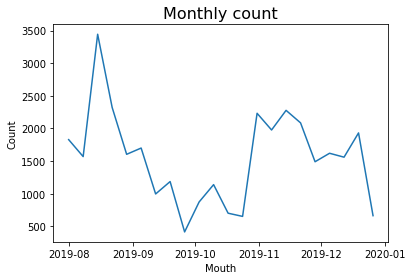

In [13]:
import matplotlib.pyplot as plt
plt.title('Monthly count', fontsize=16)
plt.plot(W_data['timestamp'],W_data['count'])
plt.ylabel('Count')
plt.xlabel('Mouth')
plt.show()

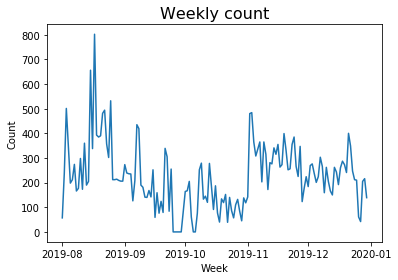

In [14]:
import matplotlib.pyplot as plt
plt.title('Weekly count', fontsize=16)
plt.plot(D_data['timestamp'],D_data['count'])
plt.ylabel('Count')
plt.xlabel('Week')
plt.show()

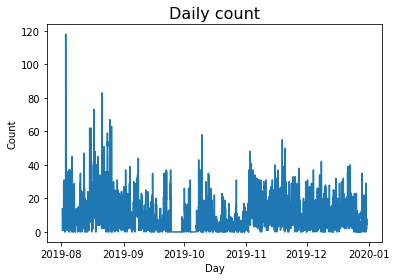

In [15]:
import matplotlib.pyplot as plt
plt.title('Daily count', fontsize=16)
plt.plot(H_data['timestamp'],H_data['count'])
plt.ylabel('Count')
plt.xlabel('Day')
plt.show()

In [16]:
data=data.groupby([pd.Grouper(key='timestamp',freq='10T')]).size().reset_index(name='count')
data['time']=pd.to_datetime(data['timestamp']).dt.round('10T').dt.strftime('%Y-%m-%d-%H-%M')  
data.drop('timestamp',inplace=True,axis=1)
data=data[["time","count"]]
data.to_csv('data2.csv',index=False)  


In [17]:
data.describe()

count
count  21788.000000
mean       1.572884
std        2.186945
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       45.000000

# LSTM

In [18]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers import LSTM,RNN
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.model_selection import StratifiedKFold,cross_val_score
%matplotlib inline

Using TensorFlow backend.


In [19]:
#Data input
dataframe = read_csv("data2.csv", usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
lookback=6
#we use 6=60min to find next 10min result
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Model Cross Validation Choose layers

In [20]:
#Model Cross Validation Choose layers
listscore = []
for layer in range(1,10):
    data = []
    for index in range(len(dataset) - lookback):
        data.append(dataset[index: index + lookback])
    data = numpy.array(data)
    row = int(round(0.7 * data.shape[0]))
    train = data[:row, :]
    numpy.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = data[row:, :-1]
    y_test = data[row:, -1]
    X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(layer, input_shape=(lookback-1,1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)
    model.summary()
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    listscore .append(testScore)
    Best=min(listscore)
    print(listscore)
    print(Best)


Epoch 1/10
15247/15247 [==============================] - 1s 56us/step - loss: 0.0028
Epoch 2/10
15247/15247 [==============================] - 0s 26us/step - loss: 0.0025
Epoch 3/10
15247/15247 [==============================] - 0s 24us/step - loss: 0.0025
Epoch 4/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0023
Epoch 5/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0020
Epoch 6/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0016
Epoch 7/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0015
Epoch 8/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0015
Epoch 9/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0015
Epoch 10/10
15247/15247 [==============================] - 0s 25us/step - loss: 0.0015
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape         

15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 4/10
15247/15247 [==============================] - 0s 28us/step - loss: 0.0015
Epoch 5/10
15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 6/10
15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 7/10
15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 8/10
15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 9/10
15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 10/10
15247/15247 [==============================] - 0s 27us/step - loss: 0.0015
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_6 (Dense)              (None, 

In [21]:
#The 10 layer have the lowest RMSE

In [22]:
#Data split
data = []
for index in range(len(dataset) - lookback):
    data.append(dataset[index: index + lookback])
data = numpy.array(data)
row = int(round(0.7 * data.shape[0]))
train = data[:row, :]
numpy.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = data[row:, :-1]
y_test = data[row:, -1]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
#Model
model = Sequential()
model.add(LSTM(9, input_shape=(lookback-1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)
model.summary()

Epoch 1/10
15247/15247 [==============================] - 1s 76us/step - loss: 0.0023
Epoch 2/10
15247/15247 [==============================] - 1s 36us/step - loss: 0.0015
Epoch 3/10
15247/15247 [==============================] - 0s 31us/step - loss: 0.0015
Epoch 4/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 5/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 6/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 7/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 8/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 9/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Epoch 10/10
15247/15247 [==============================] - 0s 29us/step - loss: 0.0015
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape         

In [24]:
#Model output
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [25]:
#RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.73 RMSE
Test Score: 1.80 RMSE


In [26]:
#Collection data
Predict = numpy.empty_like(dataset)
Predict[:, :] = numpy.nan
Predict[lookback:len(trainPredict)+lookback, :] = trainPredict
Predict[len(trainPredict)+(lookback):, :] = testPredict

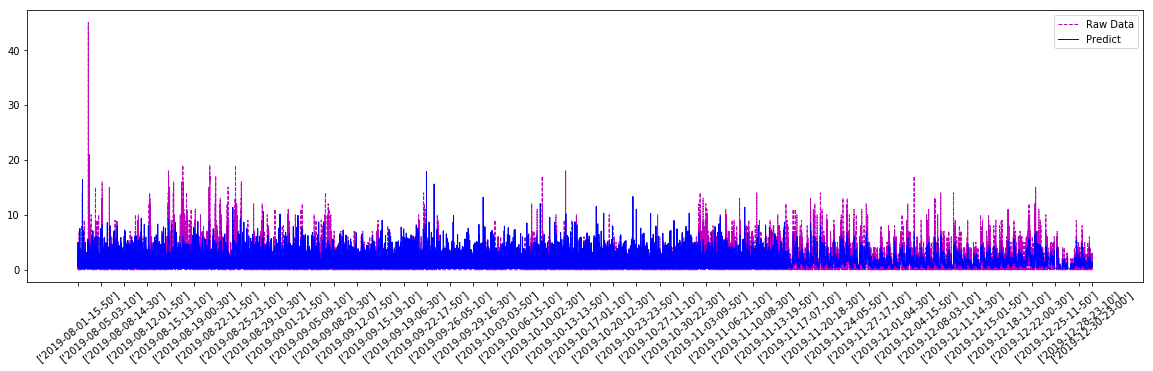

In [27]:
#Chart output
raw = scaler.inverse_transform(dataset)
x = read_csv("data2.csv",usecols=[0]).values.tolist()
fig, ax = plt.subplots(figsize=(20,5))
raw_line, = plt.plot(raw, "m--", linewidth=1, label="Raw Data")   
Predict_line, = plt.plot(Predict, "b-", linewidth=1, label="Predict") 

 
plt.legend(handles=[raw_line,Predict_line])
 
xticks=list(range(0,len(x),500))
xlabels=[x[t] for t in xticks]
xticks.append(len(x))
xlabels.append(x[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
 
plt.show()

In [29]:
#Predict output
Predict=np.ceil(Predict)
outputdata=Predict.tolist()
dataframe = read_csv("data2.csv", usecols=[0])
dataframe['predict']=pd.DataFrame(outputdata)
dataframe.to_csv('predict2.csv',index=False)

# RNN

In [30]:
#Data input
dataframe = read_csv("data2.csv", usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
lookback=6

In [31]:
#Data split
data = []
for index in range(len(dataset) - lookback):
    data.append(dataset[index: index + lookback])
data = numpy.array(data)
row = int(round(0.7 * data.shape[0]))
train = data[:row, :]
numpy.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = data[row:, :-1]
y_test = data[row:, -1]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [32]:
#Model
model = tf.keras.Sequential()
RNN = layers.SimpleRNN
model.add(RNN(1, input_shape=(lookback-1,1)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=100,verbose=1)
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
15247/15247 [==============================] - 1s 72us/sample - loss: 5.2219
Epoch 2/10
15247/15247 [==============================] - 0s 15us/sample - loss: 5.2015
Epoch 3/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1939
Epoch 4/10
15247/15247 [==============================] - 0s 15us/sample - loss: 5.1902
Epoch 5/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1882
Epoch 6/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1869
Epoch 7/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1860
Epoch 8/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1855
Epoch 9/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1850
Epoch 10/10
15247/15247 [==============================] - 0s 14us/sample - loss: 5.1847


In [33]:
#RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.28 RMSE
Test Score: 2.14 RMSE


In [34]:
#Predict output
Predict1 = numpy.empty_like(dataset)
Predict1[:, :] = numpy.nan
Predict1[lookback:len(trainPredict)+lookback, :] = trainPredict
Predict1[len(trainPredict)+(lookback):, :] = testPredict

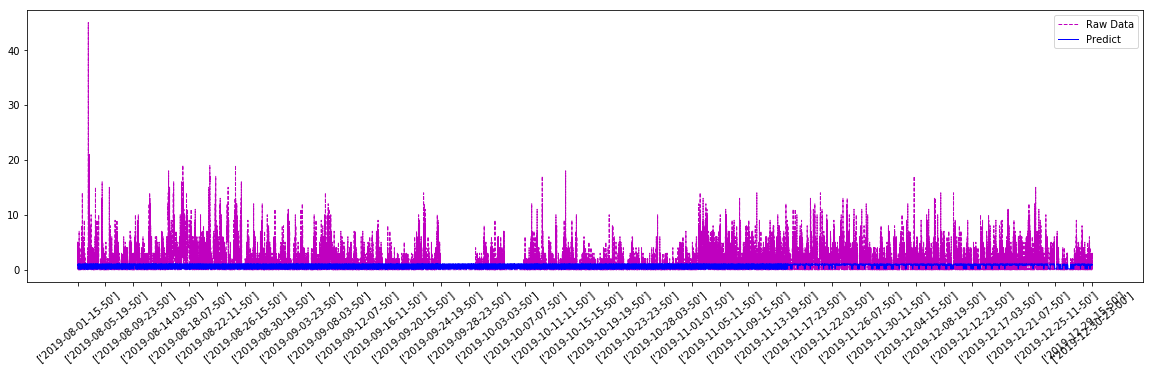

In [35]:
#Chart output
x = read_csv("data2.csv",usecols=[0]).values.tolist()
fig, ax = plt.subplots(figsize=(20,5))
raw_line, = plt.plot(dataset, "m--", linewidth=1, label="Raw Data")   
Predict_line, = plt.plot(Predict1, "b-", linewidth=1, label="Predict") 

 
plt.legend(handles=[raw_line,Predict_line])
 
xticks=list(range(0,len(x),600))
xlabels=[x[t] for t in xticks]
xticks.append(len(x))
xlabels.append(x[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
 
plt.show()

# GRU

In [36]:
#Data input
dataframe = read_csv("data2.csv", usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
lookback=6

In [37]:
#Data split
data = []
for index in range(len(dataset) - lookback):
    data.append(dataset[index: index + lookback])
data = numpy.array(data)
row = int(round(0.7 * data.shape[0]))
train = data[:row, :]
numpy.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = data[row:, :-1]
y_test = data[row:, -1]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [38]:
#Model
model = Sequential()
model.add(GRU(9, return_sequences=True,input_shape=(lookback-1,1)))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_train, y_train),verbose=1)
model.summary()
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

Train on 15247 samples, validate on 15247 samples
Epoch 1/10
15247/15247 [==============================] - 2s 106us/step - loss: 3.3634 - val_loss: 3.1608
Epoch 2/10
15247/15247 [==============================] - 1s 40us/step - loss: 3.1208 - val_loss: 3.0760
Epoch 3/10
15247/15247 [==============================] - 1s 40us/step - loss: 3.0645 - val_loss: 3.0469
Epoch 4/10
15247/15247 [==============================] - 1s 40us/step - loss: 3.0453 - val_loss: 3.0255
Epoch 5/10
15247/15247 [==============================] - 1s 40us/step - loss: 3.0419 - val_loss: 3.0766
Epoch 6/10
15247/15247 [==============================] - 1s 41us/step - loss: 3.0319 - val_loss: 3.0087
Epoch 7/10
15247/15247 [==============================] - 1s 40us/step - loss: 3.0252 - val_loss: 3.0503
Epoch 8/10
15247/15247 [==============================] - 1s 38us/step - loss: 3.0206 - val_loss: 3.0004
Epoch 9/10
15247/15247 [==============================] - 1s 40us/step - loss: 3.0114 - val_loss: 2.9962
Epoc

In [39]:
#RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.73 RMSE
Test Score: 1.80 RMSE


In [40]:
#Predict output
Predict2 = numpy.empty_like(dataset)
Predict2[:, :] = numpy.nan
Predict2[lookback:len(trainPredict)+lookback, :] = trainPredict
Predict2[len(trainPredict)+(lookback):, :] = testPredict

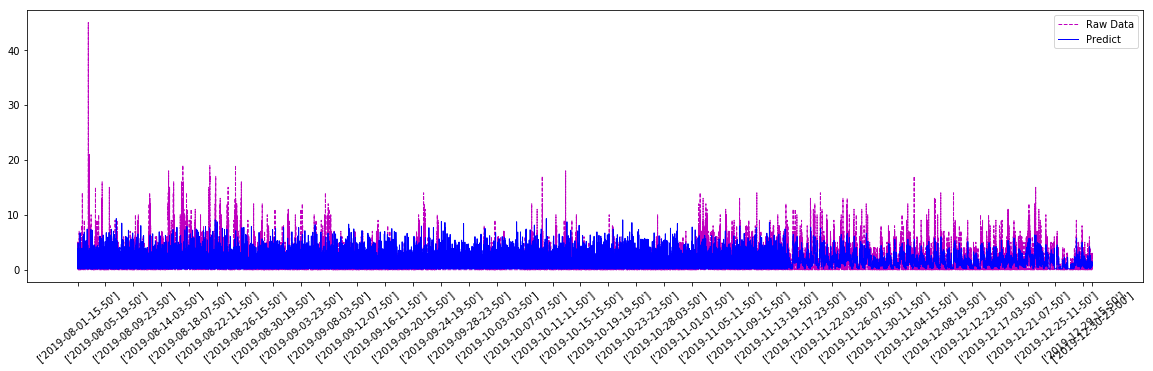

In [41]:
#Chart output
x = read_csv("data2.csv",usecols=[0]).values.tolist()
fig, ax = plt.subplots(figsize=(20,5))
raw_line, = plt.plot(dataset, "m--", linewidth=1, label="Raw Data")   
Predict_line, = plt.plot(Predict2, "b-", linewidth=1, label="Predict") 

 
plt.legend(handles=[raw_line,Predict_line])
 
xticks=list(range(0,len(x),600))
xlabels=[x[t] for t in xticks]
xticks.append(len(x))
xlabels.append(x[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
 
plt.show()